In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.style.use('ggplot')
import seaborn as sns
import statistics

In [2]:
results = pd.read_csv("test_results/all_queries_test_results.csv") 
test_name = "all_queries"

results = results.rename(columns={"Average": "Mean"})

In [4]:
results.head()

,Data Type,Scaling Factor,Query Name,Query Number,Mean,Runs
0,SQL,1,SQL,Query 1,5.360,"[5.417200326919556, 5.148321628570557, 5.40635..."
1,Pandas,1,Pandas Converter,Query 1,2.830,"[2.9908876419067383, 2.7867038249969482, 2.788..."
2,SQL,1,SQL,Query 2,1.100,"[1.0946803092956543, 1.1217174530029297, 1.087..."
3,Pandas,1,Pandas Converter,Query 2,0.723,"[0.7768778800964355, 0.7044978141784668, 0.729..."
4,SQL,1,SQL,Query 3,1.850,"[1.8838984966278076, 1.8208110332489014, 1.806..."


In [5]:
# Sort Query Name column to in-order
def extract_number(name):
    return int(name.split(" ")[1])

results['Query Number'] = results.apply(lambda row : extract_number(row['Query Number']), axis = 1)
results = results.sort_values(['Query Number'])

# Fix the runs column
def fix_runs(runs):
    new_runs = list(str(str(runs)[1:-1]).split(","))
    for i in range(0, len(new_runs)):
        new_runs[i] = float(new_runs[i].strip())
    return new_runs

results['Runs'] = results.apply(lambda row : fix_runs(row['Runs']), axis = 1)

results['Median'] = results.apply(lambda row: statistics.median(sorted(row['Runs'])), axis = 1)

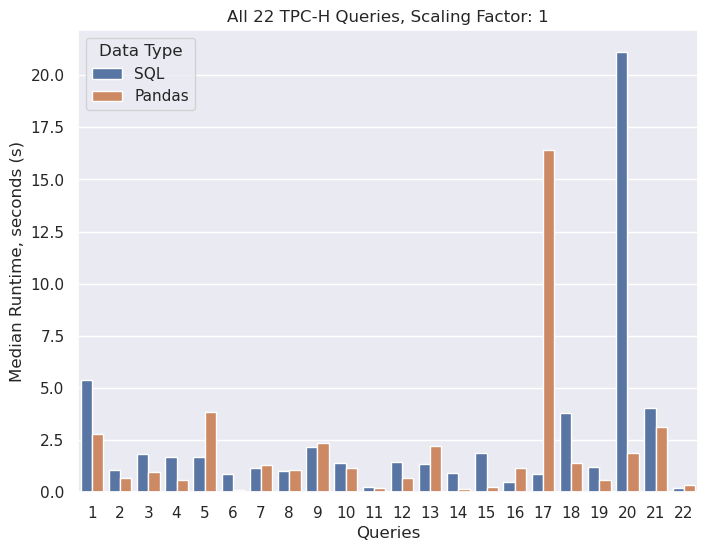

In [10]:
# plot with seaborn barplot
sns.set(rc={'figure.figsize':(8,6)})
ax = sns.barplot(data=results, x='Query Number', y='Median', hue='Data Type')
#ax.set_yscale("log")
ax.set(xlabel='Queries', ylabel='Median Runtime, seconds (s)')
plt.title("All 22 TPC-H Queries, Scaling Factor: 1")
#set parameters for tick labels
plt.tick_params(axis='x', which='major', labelsize=11)
#plt.tick_params(axis='y', which='major', labelsize=10)
plt.savefig("analysis_results/" + str(test_name) + "_compare_queries.svg")
plt.show()

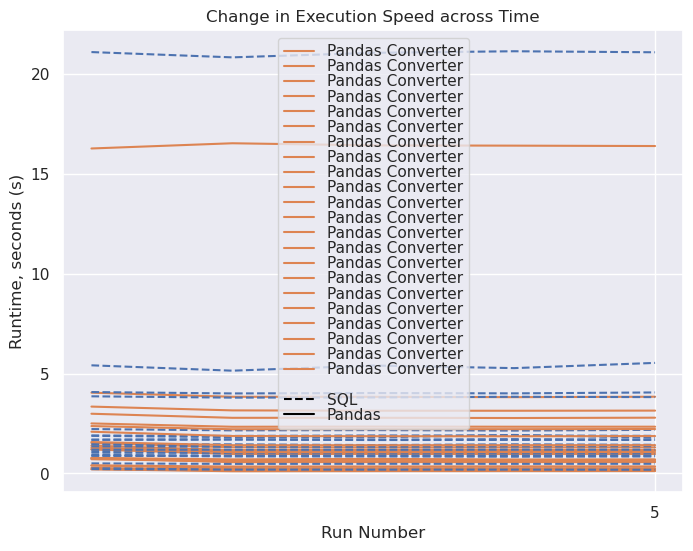

In [8]:
# Make graph of change in runtimes
# Y: Run time, X: Run Number
# Line: Query Number
prev_colors = {}

fig, ax = plt.subplots()

for index, row in results.iterrows():
    if row["Data Type"] == "SQL":
        line_style = 'dashed'
        legend_info = None
    else:
        line_style = 'solid'
        legend_info = row["Query Name"]
    
    # Choose line color
    if prev_colors.get(row["Query Name"], None) == None:
        # Not in dataframe
        line = ax.plot(list(range(1, len(row["Runs"])+1)), row["Runs"], label=legend_info, linestyle=line_style)
        prev_colors[row["Query Name"]] = line[0].get_color()
    else:
        color_line = prev_colors[row["Query Name"]]
        ax.plot(list(range(1, len(row["Runs"])+1)), row["Runs"], label=legend_info, linestyle=line_style, color=color_line)

# Add extra info to legend
ax.plot([], [], " ", label=" "*5,)
ax.plot([], [], label="SQL", color="black", linestyle="dashed")
ax.plot([], [], label="Pandas", color="black", linestyle="solid")

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(1))

plt.title('Change in Execution Speed across Time')
plt.xlabel('Run Number')
plt.ylabel('Runtime, seconds (s)')
ax.legend(labelspacing=0.01)
plt.savefig("analysis_results/" + str(test_name) + "_compare_queries_exec_time.pdf")
plt.show()